In [ ]:
# !pip install yfinance

In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import hashlib
import json
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100.0

print("TensorFlow:", tf.__version__)
print("Using CUDA GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.20.0
Using CUDA GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [36]:
# end_date = datetime.now()
end_date = "2025-11-24"
start_date = "2003-09-18"
horizon = "1d"

print("Start date:", start_date)
print("End date:", end_date)

Start date: 2003-09-18
End date: 2025-11-24


In [37]:
gold = yf.download("GC=F", start = start_date, end = end_date, interval = horizon, auto_adjust = False)
silver = yf.download("SI=F", start = start_date, end = end_date, interval = horizon,auto_adjust = False)
cad = yf.download("CADUSD=X", start = start_date, end = end_date, interval = horizon, auto_adjust = False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [38]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5572 entries, 2003-09-18 to 2025-11-21
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, GC=F)  5572 non-null   float64
 1   (Close, GC=F)      5572 non-null   float64
 2   (High, GC=F)       5572 non-null   float64
 3   (Low, GC=F)        5572 non-null   float64
 4   (Open, GC=F)       5572 non-null   float64
 5   (Volume, GC=F)     5572 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 304.7 KB


In [39]:
silver.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5573 entries, 2003-09-18 to 2025-11-21
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, SI=F)  5573 non-null   float64
 1   (Close, SI=F)      5573 non-null   float64
 2   (High, SI=F)       5573 non-null   float64
 3   (Low, SI=F)        5573 non-null   float64
 4   (Open, SI=F)       5573 non-null   float64
 5   (Volume, SI=F)     5573 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 304.8 KB


In [40]:
cad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5770 entries, 2003-09-18 to 2025-11-21
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, CADUSD=X)  5770 non-null   float64
 1   (Close, CADUSD=X)      5770 non-null   float64
 2   (High, CADUSD=X)       5770 non-null   float64
 3   (Low, CADUSD=X)        5770 non-null   float64
 4   (Open, CADUSD=X)       5770 non-null   float64
 5   (Volume, CADUSD=X)     5770 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 315.5 KB


In [41]:
def asset_heatmap(df, asset_name):
    plt.figure(figsize=(7, 5))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title(f"{asset_name} Feature Correlation Heatmap")
    plt.show()

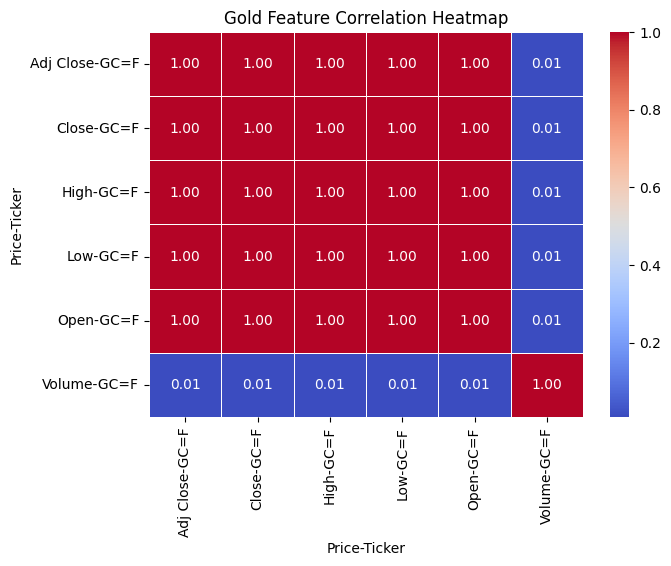

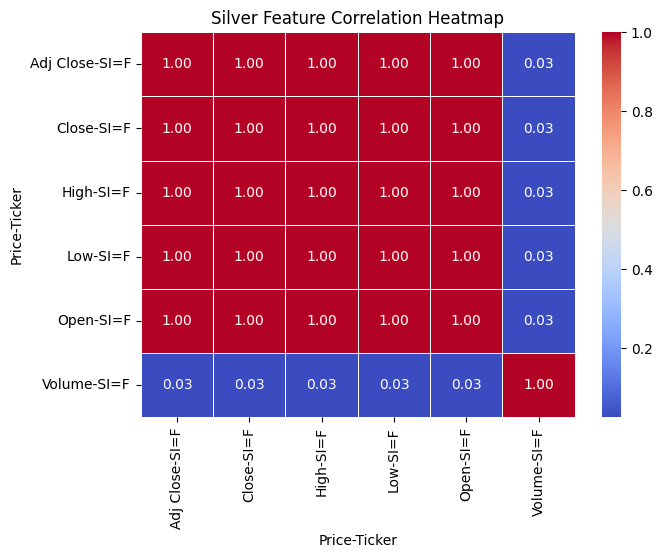

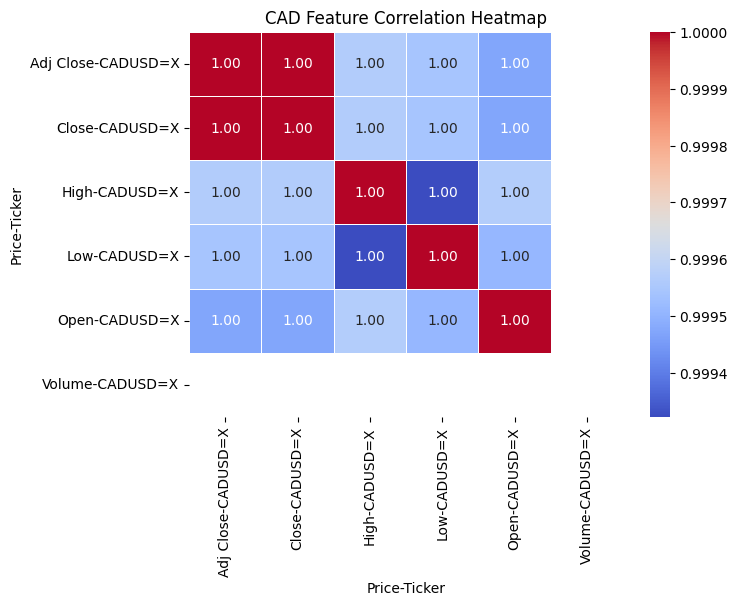

In [42]:
asset_heatmap(gold, "Gold")
asset_heatmap(silver, "Silver")
asset_heatmap(cad, "CAD")

In [43]:
gold = gold[["Close"]].rename(columns={"Close": "Gold"})
silver = silver[["Close"]].rename(columns={"Close": "Silver"})
cad = cad[["Close"]].rename(columns={"Close": "CAD"})

In [44]:
all_prices = gold.join([silver, cad], how="outer")
all_prices.to_csv("prices_with_null.csv")

In [45]:
all_prices = all_prices.ffill().bfill() # forward-fill + backward-fill to deal with missing values
all_prices.to_csv("prices.csv")

In [46]:
all_prices.head()

Price,Gold,Silver,CAD
Ticker,GC=F,SI=F,CADUSD=X
Date,,,
2003-09-18,376.600006,5.255,0.734484
2003-09-19,381.799988,5.282,0.742280
2003-09-22,387.200012,5.265,0.738443
2003-09-23,385.899994,5.235,0.737953
2003-09-24,387.500000,5.302,0.740686


In [47]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5785 entries, 2003-09-18 to 2025-11-21
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Gold, GC=F)     5785 non-null   float64
 1   (Silver, SI=F)   5785 non-null   float64
 2   (CAD, CADUSD=X)  5785 non-null   float64
dtypes: float64(3)
memory usage: 180.8 KB


In [48]:
all_prices.describe()

Price,Gold,Silver,CAD
Ticker,GC=F,SI=F,CADUSD=X
count,5785.000000,5785.000000,5785.000000
mean,1364.121088,19.550137,0.837579
std,652.181083,8.362776,0.100352
min,369.200012,4.810000,0.679486
25%,935.599976,14.400000,0.753852
50%,1288.400024,17.683001,0.798537
75%,1729.199951,24.238001,0.935716
max,4336.399902,53.332001,1.088495


## feature engineering

In [49]:
# # adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

# all_prices = all_prices.dropna()

In [50]:
# all_prices.head()

In [51]:
# all_prices.to_csv("prices_engineered.csv")

In [52]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(all_prices)

# scaled_prices = pd.DataFrame(scaled, index=all_prices.index, columns=all_prices.columns)

In [53]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

window = 40
X, y = create_sequences(scaled, window)

train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [54]:
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(window, 3)),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
#     Dense(32, activation="relu"),
    Dense(3)
])

model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

/home/rita/anaconda3/envs/Python3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 40, 64)         │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,755 (88.89 KB)

 Trainable params: 22,755 (88.89 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.5, patience=10, min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[earlystop, reduceLR],
    verbose=1
)

Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0166 - mean_absolute_error: 0.0872 - mean_squared_error: 0.0166 - val_loss: 6.8282e-04 - val_mean_absolute_error: 0.0206 - val_mean_squared_error: 6.8282e-04 - learning_rate: 0.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - mean_absolute_error: 0.0560 - mean_squared_error: 0.0059 - val_loss: 7.2393e-04 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 7.2393e-04 - learning_rate: 0.0010
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mean_absolute_error: 0.0476 - mean_squared_error: 0.0043 - val_loss: 3.2576e-04 - val_mean_absolute_error: 0.0139 - val_mean_squared_error: 3.2576e-04 - learning_rate: 0.0010
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - mean_absolute_error: 0.0421 - mean_squared_error: 0.0035 - val_loss: 4.6338e-04 - val_mean_absolute_error: 0.0173 - val_mean_squared_error: 4.6338e-04 - learning_rate: 0.0010
Epoch 5/50
130/130 ━━━━

In [56]:
y_pred = model.predict(X_test)

# inverse scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [57]:
baseline = scaler.inverse_transform(X_test[:, -1, :]) # last real point

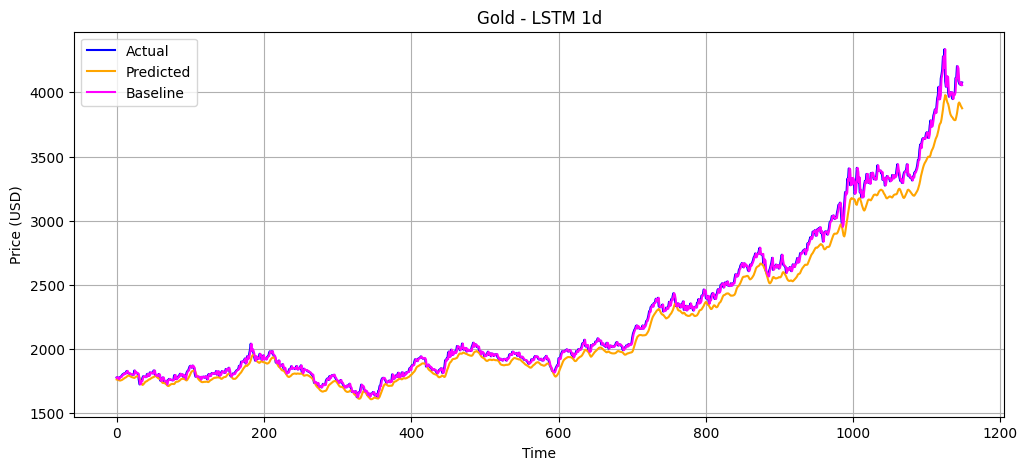

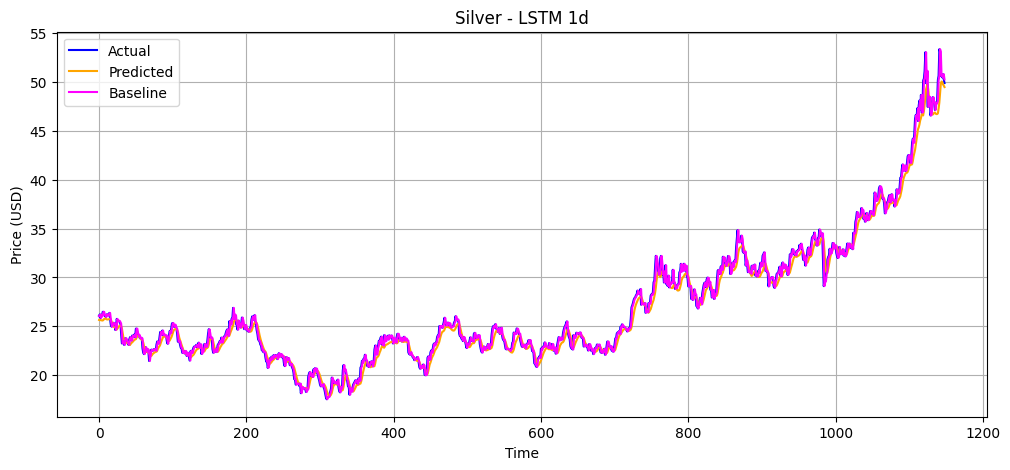

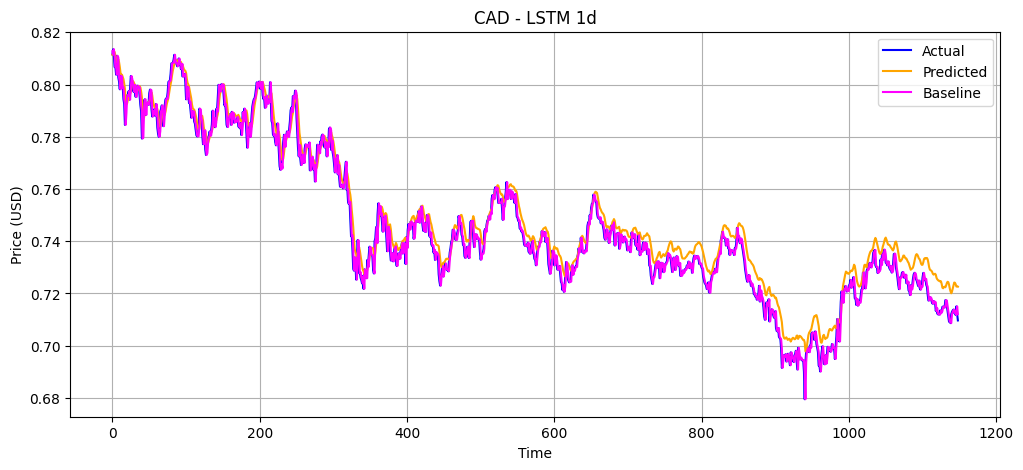

In [58]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.title(f"{asset_name} - LSTM 1d")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [59]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 74.52244723247797
 RMSE: 96.68348207491862
 MAPE: 2.9728098549528097

Silver
 MAE : 0.6406730406174358
 RMSE: 0.8704369048991238
 MAPE: 2.3177802258067763

CAD
 MAE : 0.005130895539093682
 RMSE: 0.006145472259459338
 MAPE: 0.6964001934311805



Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): 20-11-2025; 28-11-2025


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


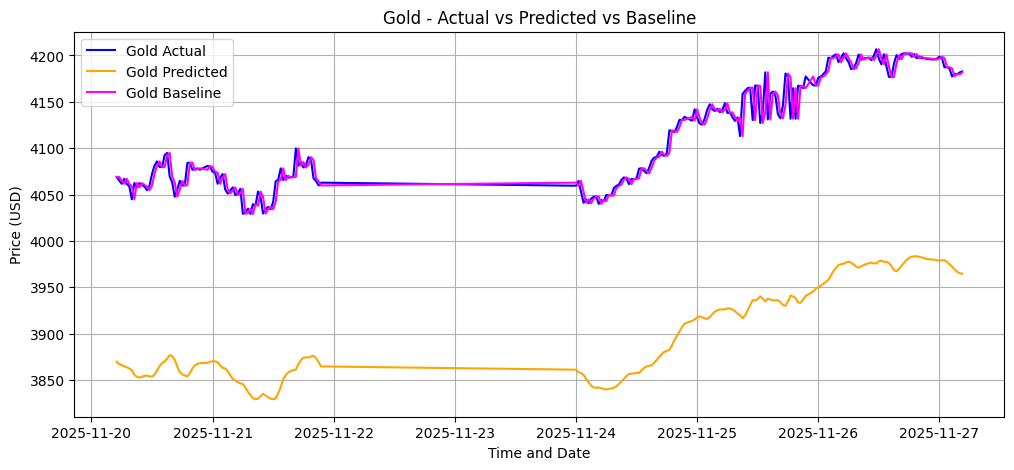

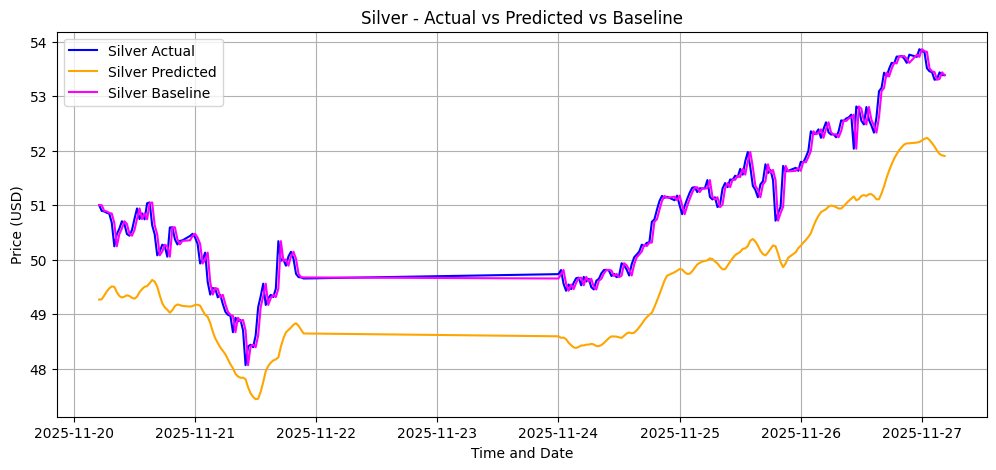

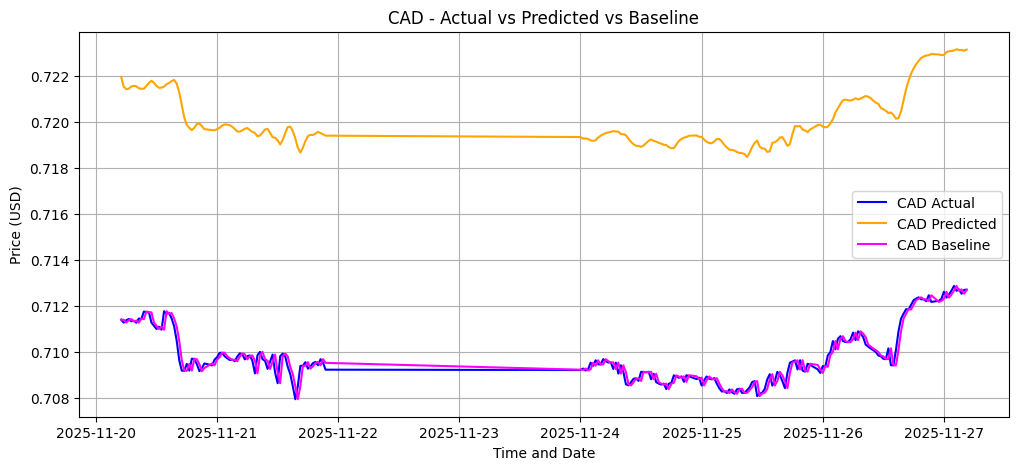

In [60]:
predict_window = 60

def parse_range(user_input): #format: DD-MM-YYYY; DD-MM-YYYY
   # Example: 10-12-2025; 14-12-2025
    if ";" not in user_input:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    parts = user_input.split(";")
    if len(parts) != 2:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    start_str = parts[0].strip()
    end_str   = parts[1].strip()

    try:
        start = datetime.strptime(start_str, "%d-%m-%Y")
        end   = datetime.strptime(end_str, "%d-%m-%Y")
    except:
        raise ValueError("Invalid date. Use exactly this format: DD-MM-YYYY; DD-MM-YYYY")

    return start, end

def user_date():
    while True:
        user_input = input("Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): ")

        try:
            start, end = parse_range(user_input)
            return user_input
        except Exception as e:
            print(f"\nError: {str(e)}\nPlease try again.\n")


def predict_range(date_string, interval="30m"):
    start, end = parse_range(date_string)

    # downloading data to be able to compare with the actual value
    gold = yf.download("GC=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Gold"})
    silver = yf.download("SI=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Silver"})
    cad = yf.download("CADUSD=X", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "CAD"})
    
    
    data = gold.join([silver, cad], how="outer").dropna()

    if data.shape[0] == 0:
        raise ValueError(
            f"No Yahoo Finance data found between {start.date()} and {end.date()} "
            f"for interval='{interval}'. "
            "Try an earlier date range that already has price history."
        )

    scaled_data = scaler.transform(data)

    X_seq = []
    last_seq = scaled[-predict_window:]
    window = np.vstack([scaled[-predict_window:], scaled_data])

    for i in range(len(data)):
        seq = window[i:i+predict_window]
        if seq.shape[0] == predict_window:
            X_seq.append(seq)

    X_seq = np.array(X_seq)

    preds = model.predict(X_seq)
    preds_inv = scaler.inverse_transform(preds)

    data["Gold_pred"], data["Silver_pred"], data["CAD_pred"] = (
        preds_inv[:, 0], preds_inv[:, 1], preds_inv[:, 2]
    )

    return data


def plot_results(df):
    assets = ["Gold", "Silver", "CAD"]
    for asset in assets:
        actual = df[asset].values
        predicted = df[f"{asset}_pred"].values
        
        # baseline: next price = current actual
        baseline = np.roll(actual, 1)
        baseline[0] = actual[0]  

        plt.figure(figsize=(12,5))
        plt.plot(df.index, actual, label=f"{asset} Actual", color="blue")
        plt.plot(df.index, predicted, label=f"{asset} Predicted", color="orange")
        plt.plot(df.index, baseline, label=f"{asset} Baseline", color="magenta")
        
        plt.title(f"{asset} - Actual vs Predicted vs Baseline")
        plt.xlabel("Time and Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()


# 20-11-2025; 28-11-2025
user_range = user_date()
user_df = predict_range(user_range, interval="30m")
plot_results(user_df)

In [61]:
user_df.head()

Price,Gold,Silver,CAD,Gold_pred,Silver_pred,CAD_pred
Ticker,GC=F,SI=F,CADUSD=X,,,
Datetime,,,,,,
2025-11-20 05:00:00+00:00,4068.899902,51.000000,0.711389,3869.716797,49.267830,0.721954
2025-11-20 05:30:00+00:00,4065.100098,50.895000,0.711263,3867.075195,49.273968,0.721527
2025-11-20 06:00:00+00:00,4061.600098,50.884998,0.711364,3866.041504,49.342068,0.721421
2025-11-20 06:30:00+00:00,4066.899902,50.860001,0.711420,3864.634277,49.415600,0.721441
2025-11-20 07:00:00+00:00,4061.399902,50.845001,0.711318,3863.729004,49.474487,0.721536


Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): 28-11-2025; 01-12-2025


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


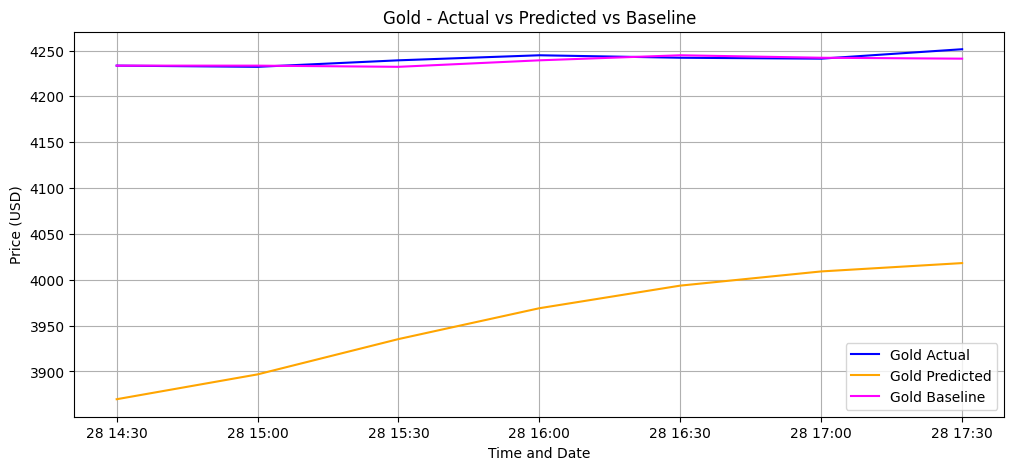

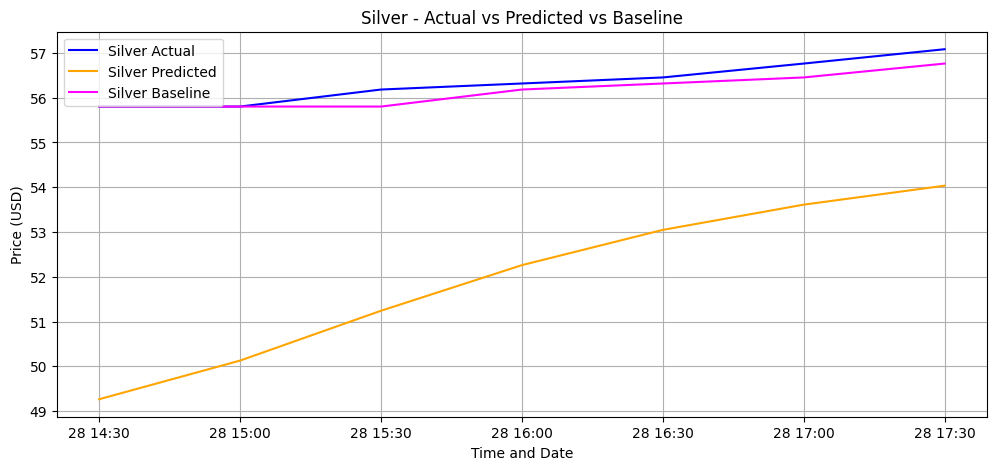

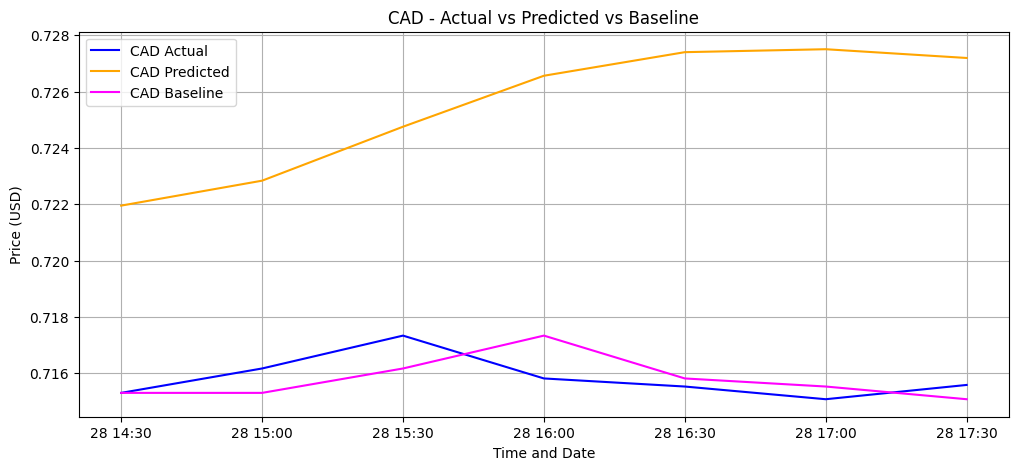

In [62]:
# 28-11-2025; 01-12-2025
user_range = user_date()
user_df = predict_range(user_range, interval="30m")
user_df.head()
plot_results(user_df)

In [63]:
user_df.head()

Price,Gold,Silver,CAD,Gold_pred,Silver_pred,CAD_pred
Ticker,GC=F,SI=F,CADUSD=X,,,
Datetime,,,,,,
2025-11-28 14:30:00+00:00,4233.500000,55.799999,0.715308,3869.682861,49.266212,0.721952
2025-11-28 15:00:00+00:00,4232.200195,55.799999,0.716173,3896.773438,50.128681,0.722837
2025-11-28 15:30:00+00:00,4239.299805,56.180000,0.717340,3935.279297,51.241592,0.724751
2025-11-28 16:00:00+00:00,4244.799805,56.314999,0.715820,3968.941650,52.259342,0.726560
2025-11-28 16:30:00+00:00,4242.100098,56.450001,0.715533,3993.586914,53.046661,0.727397
